## data ##

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch.utils.data as td

### original image ###

Original image shape is (192, 168)


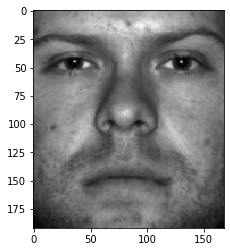

In [2]:
img = Image.open('data/CroppedYale/yaleB01/yaleB01_P00A+000E+00.pgm')
img = np.array(img)
print("Original image shape is", img.shape)
plt.imshow(img, cmap='gray')
plt.show()

### processed image loaded from ExtendedYaleFace dataset ###

Total number of images is 1931
Dimension of the batch data is torch.Size([4, 1, 32, 32])
Batch size is 4
Channel is 1
Image shape is resized to: torch.Size([32, 32])


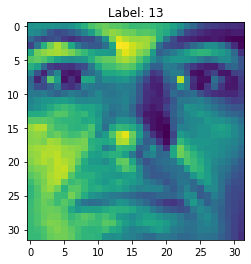

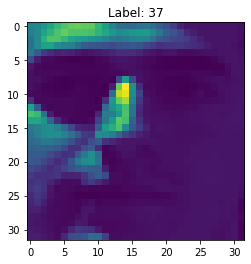

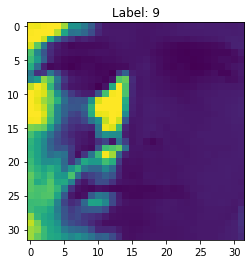

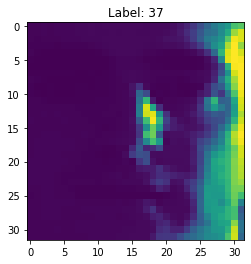

In [3]:
from dataset import ExtendedYaleFace

# training dataset (unflattened, normalized to [-1, 1])
train_set = ExtendedYaleFace(root="data/CroppedYale", image_shape=[32, 32], flatten=False, normalize=True, train=True)
print("Total number of images is", train_set.__len__())

# dataloader
train_loader = td.DataLoader(train_set, batch_size=4, shuffle=False)

# visualize the first batch
for batch_idx, (image_batch, labels) in enumerate(train_loader):
    if batch_idx >= 1:
        break
    print("Dimension of the batch data is", image_batch.shape)
    print("Batch size is", image_batch.shape[0])
    print("Channel is", image_batch.shape[1])
    print("Image shape is resized to:", image_batch.shape[2:])
    for img_idx, img in enumerate(image_batch):
        plt.title("Label: %d" % labels[img_idx])
        plt.imshow(img.squeeze(0))
        plt.show()

## PCA ##

Dimension of the batch data is torch.Size([1931, 1, 1024])


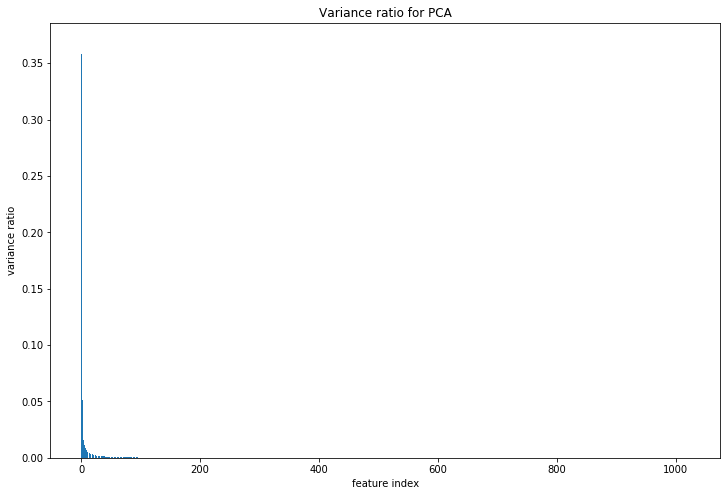

In [4]:
from features import *

# training dataset (flattened, normalized to [-1, 1])
train_set = ExtendedYaleFace(root="data/CroppedYale", image_shape=[32, 32], flatten=True, normalize=True, train=True)
pca = pca_fit(train_set)
    
# plot variance ratio
plt.figure(figsize=(12, 8))
plt.title("Variance ratio for PCA")
plt.bar(np.arange(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.xlabel("feature index")
plt.ylabel("variance ratio")
plt.show()

### visualize first 10 eigenfaces ###

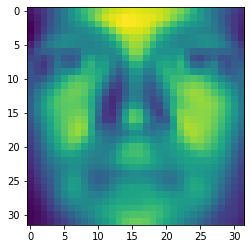

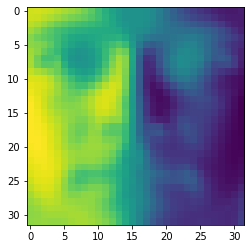

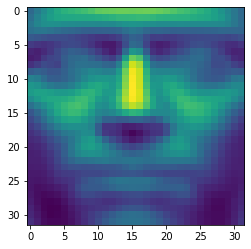

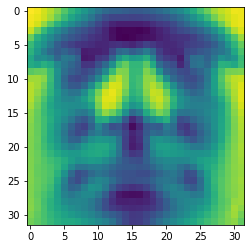

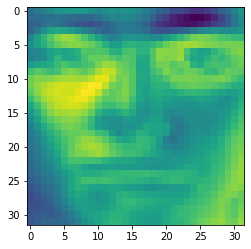

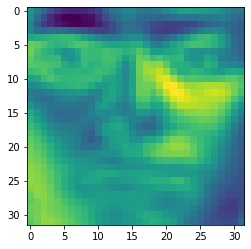

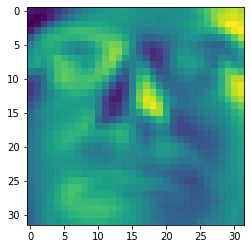

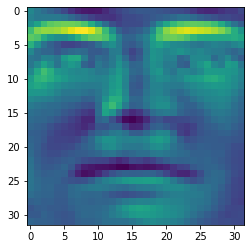

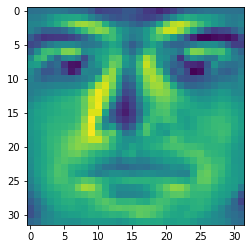

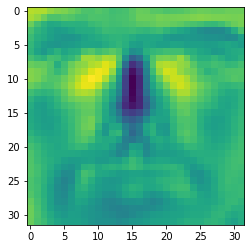

In [5]:
eigenfaces = pca.components_.reshape(-1, 32, 32)

for i in range(10):
    plt.imshow(eigenfaces[i])
    plt.show()

### reconstruct using first 10 basis ###

Dimension of the batch data is torch.Size([483, 1, 1024])


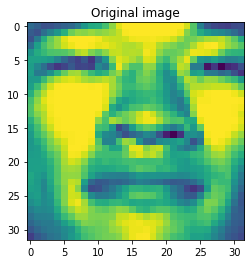

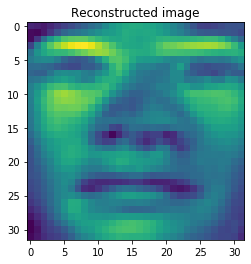

In [6]:
# test dataset (flattened, normalized to [-1, 1])
test_set = ExtendedYaleFace(root="data/CroppedYale", image_shape=[32, 32], flatten=True, normalize=True, test=True)
X_test_transformed = pca_transform(pca, test_set)

# dataloader
test_loader = td.DataLoader(test_set, batch_size=1, shuffle=False)

# original image
img_original, _ = next(iter(test_loader))
plt.title("Original image")
plt.imshow(img_original.squeeze().numpy().reshape(32, 32))
plt.show()

# reconstructed image
img_reconstructed = np.zeros((32, 32))
for i in range(10):
    img_reconstructed += X_test_transformed[0, i] * eigenfaces[i]
plt.title("Reconstructed image")
plt.imshow(img_reconstructed)
plt.show()

## LBP ##

In [7]:
# training dataset (unflattened, normalized to [-1, 1])
train_set = ExtendedYaleFace(root="data/CroppedYale", image_shape=[32, 32], flatten=False, normalize=True, train=True)

# dataloader
train_loader = td.DataLoader(train_set, batch_size=1, shuffle=False)

X_train_transformed = lbp_transform(train_set)
print(X_train_transformed.shape)

(1931, 32, 32)


### visualize LBP and corresponding histogram ###

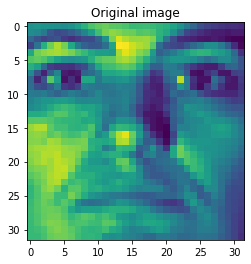

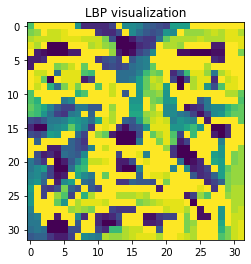

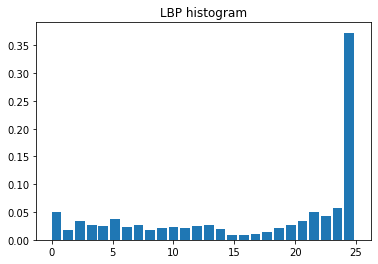

In [8]:
# original image
img_original, _ = next(iter(train_loader))
plt.title("Original image")
plt.imshow(img_original.squeeze().numpy())
plt.show()

# LBP
plt.title("LBP visualization")
plt.imshow(X_train_transformed[0])
plt.show()

# histogram
plt.title("LBP histogram")
plt.hist(X_train_transformed[0].ravel(), bins=int(X_train_transformed.max()+1), density=True, width=0.8)
plt.show()